<img src="https://datascopeanalytics.com/static/img/websitelogos-06.png"></img>


<b><font size="24"><center> Assignment - May 2017 </center> </font><b>
.
<font size="3em"> <center> Author:  <a href = "https://www.linkedin.com/in/alexanderfo/"> Alexander Fred Ojala </a> </font> </center>

___

# Part 0: Notebook requirements
This notebook runs Python 3.5 code.

Required libraries:
* Numpy
* Pandas
* Matplotlib
* folium (for map plotting [Folium Github repo](https://github.com/python-visualization/folium))
* vincent (for map visualization [Vincent Github repo](https://github.com/wrobstory/vincent))

Data sets:
* [Chicago L stop people entries, stored in variable `df`](https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f)
* [Chicago L stop stations info](https://data.cityofchicago.org/Transportation/CTA-System-Information-List-of-L-Stops/8pix-ypme) (only used to extract location coordinates)

# Part 1: Exploration of data sets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!ls

Datascope Assignment and Presentation.ipynb
chi_map.html
chi_map2.html
list_of_stops.csv
ridershipreadme.txt
station_entries.csv


In [3]:
print(open("ridershipreadme.txt", "r").read())

Ridership Readme 
12-Aug-2011
Chicago Transit Authority

* About CTA ridership numbers *
Ridership statistics are provided on a system-wide and bus route/station-level basis. Ridership is primarily counted as boardings, that is, customers boarding a transit vehicle (bus or rail).  On the rail system, there is a distinction between station entries and total rides, or boardings. Datasets indicate such in their file name and description.

* How people are counted on the 'L' *
On the rail system, a customer is counted as an "entry" each time he or she passes through a turnstile to enter a station.  Customers are not counted as "entries" when they make a "cross-platform" transfer from one rail line to another, since they don't pass through a turnstile. Where the number given for rail is in "boardings," what's presented is a statistically valid estimate of the actual number of boardings onto the rail system. 

* How people are counted on buses *
Boardings are recorded using the bus farebox a

In [4]:
# Read in station entries data
df = pd.read_csv('station_entries.csv')

In [5]:
df.head()

station_id         stationname        date daytype  rides
0       40010  Austin-Forest Park  01/01/2001       U    290
1       40020         Harlem-Lake  01/01/2001       U    633
2       40030        Pulaski-Lake  01/01/2001       U    483
3       40040        Quincy/Wells  01/01/2001       U    374
4       40050               Davis  01/01/2001       U    804

In [6]:
df.shape

(826894, 5)

In [7]:
df['rides'].describe()

count    826894.000000
mean       3288.135780
std        3160.906672
min           0.000000
25%        1117.000000
50%        2307.000000
75%        4340.000000
max       36323.000000
Name: rides, dtype: float64

In [8]:
# convert date to datetime object

df.set_index(pd.to_datetime(df['date'], format='%m/%d/%Y'), inplace = True)

In [9]:
df = df.drop('date',axis=1)

In [10]:
df.head()

station_id         stationname daytype  rides
date                                                     
2001-01-01       40010  Austin-Forest Park       U    290
2001-01-01       40020         Harlem-Lake       U    633
2001-01-01       40030        Pulaski-Lake       U    483
2001-01-01       40040        Quincy/Wells       U    374
2001-01-01       40050               Davis       U    804

# Part 2: Warmup Questions

## Q1: Which stop has the highest average ridership per day, and what is it?

In [11]:
print("Number of Station ID's':", len(df['station_id'].unique()))
print("Number of unique station name's:", len(df['stationname'].unique()))

Number of Station ID's': 146
Number of unique station name's: 147


In [12]:
# Just for fun, find what station ID that is duplicated

pd.DataFrame(list(df.groupby(['stationname','station_id']).count() \
                  .index.values),columns=['name','id']).groupby('id').count() \
                  .sort_values('name',ascending=False).head(3)

print('The two stations with different names, but same ID are:', df[df['station_id']==40140]['stationname'].unique())

The two stations with different names, but same ID are: ['Skokie' 'Dempster-Skokie']


### **Assumption: ** The station ID's are unique (i.e. Skokie and Dempster-Skokie are the same station).

#### Therefore, the number of `station names` $\neq$ the number of `station ID's`

In [13]:
# Calculate total number of days
num_days = len(df.index.unique().values)

In [14]:
# Calculate average number of riderships / day
tot_rides = df[['station_id','rides']].groupby('station_id').sum() \
                    .sort_values('rides',ascending=False).head(3)
tot_rides.columns = ['tot_rides/station']
    
tot_rides

tot_rides/station
station_id                   
40380                79426161
41660                77337160
41450                75249013

In [15]:
# Average ridership per day and station
avg_rides = tot_rides.values[0] / num_days
print(avg_rides)

[ 13663.54051264]


In [16]:
# Find station name
hi_station = df.loc[df['station_id'] == tot_rides.index.values[0]]['stationname'][0]
print(hi_station)

Clark/Lake


In [17]:
## ANSWER TO Q1 ##

print('The station with the highest average ridership per day is:', hi_station)
print('The average number of riderships per day at', hi_station, 'is:', str(np.round(avg_rides[0], 2)))

The station with the highest average ridership per day is: Clark/Lake
The average number of riderships per day at Clark/Lake is: 13663.54


## Q2: Which stop has the greatest standard deviation in weekday (exclude holidays) ridership per day, and what is it?

In [18]:
# Create DataFrame with only weekday values

df_w = df[df['daytype'].str.contains("W")]

In [19]:
# Extract standard deviation in weekday ridership / day
std_rides = df.groupby('station_id').std().sort_values('rides',ascending=False).head(3)
std_rides

rides
station_id             
40380       6590.492180
41660       5563.235581
40560       3841.539070

In [20]:
# Find station name
std_station = df.loc[df['station_id'] == std_rides.index.values[0]]['stationname'][1]
print(std_station)

Clark/Lake


In [21]:
## ANSWER TO Q2 ##

print('The station with the highest average ridership per day is:', std_station)
print('The average number of riderships per day at', std_station, 'is:', np.round(float(std_rides.iloc[0,0]), 2))

The station with the highest average ridership per day is: Clark/Lake
The average number of riderships per day at Clark/Lake is: 6590.49


___

# Challenge question

Imagine you’re a business owner in Chicago looking to open a new location. Any kind of business will do. In the form of writing, potentially supplemented by sketches (computer-drawn or hand-drawn) and links, we want to see your response to these questions:

* 1: What questions could you potentially explore/answer with this data?
* 2: Ideally, what other data would you gather or combine to learn even more?
* 3: How would you want to see data presented, to make it actionable by you or others?
* 4: Furthermore, we want to see the results of 1–3 hours of work, using the real data, towards making those ideas a reality. The results could include findings from the data, code, Jupyter/R notebooks, a spreadsheet, a visualization, results of a statistical model you built, etc. Try not to hide things or throw them away— we want to see your work!

# Answer to Challenge Question

Choice of business and location preferences: I wanna start a pizza restaurant in Chicago, somewhere close to a busy subway station on the "L" line.

### 1: What questions could you potentially explore/answer with this data?

* What is the busiest station on the "L" line on weekdays, Saturdays, Sundays / Holidays?
* Should it be open every day (or should it for example be closed on weekends, Sundays, or weekdays)?
* Since the data provides exact date stamps, we can also answer questions on if it is worth to be open on holidays such as Christmas, New Years, MLK day, etc.
* We could also see what seasons would be the most lucrative, and when a good opening day would be (i.e. the day with the most people passing the station)
* We could see the increase or decrease in the number of passengers for each stop over time -- in order to determine if it's an up and coming neighbourhood (and do projections about the number of future passengers)

### 2: Ideally, what other data would you gather or combine to learn even more?

* Restaurants operating at each subway stop, and what type of food they are serving and at what price level.
* Restaurants that have been closed down at the subway stops before.
* Opening Hours of other restaurants at each stop
* A data set with the ridership per station divded into hours -- to know when to staff up etc.
* The socioeconomic standard in the neighbourhood -- and how often people eat out.
* The weather data for each station (a sunnier station might be better, because then people tend to eat more takeaway.
* Rent prices in the proximity to the different subway stations.
* Average salaries for people working in the restaurant industry in the area.
* Number of restaurants that have opened / closed in the area during the last couple of years (to see if it's an up and coming neighbourhood).

### 3: How would you want to see data presented, to make it actionable by you or others?

I would like to see the data presented in an interactive web application where you can choose what station you're thinking about opening the restaurant in and then customize the different input variables (like price level to customers, price of ingredients (quality), opening hours etc.), and then the web application would use a prediction algorithm to determine what location would be most suitable to open the specific business in.

This could be built using Flask as a backend and React + d3.js in the Front-end. Everything could be hosted on an EC2 server and it could be deployed using Nginx and gunicorn.

I could probably build this in 3-4 days -- but time is kind of short now. Therefore, I've instead compiled a presentation of the most lucrative sub-station to open a pizzeria in, in regards to some criteria's. See below:

### 4: Explore a solution to the problem

In [22]:
# First utilize the given data sets about number of people at each stop -- to determine
# which three stops we should do an extended analysis on.

In [23]:
## Print busiest stops on weekdays, saturdays, Sundays / holidays + only holidays

In [24]:
date_cats = list(df['daytype'].unique()) # W = Weekday, U = Saturday, U = Sunday + Holiday
print(date_cats)

['U', 'W', 'A']


In [25]:
# Find 5 busiests stops for every date category

df_res = pd.DataFrame()

for cat in date_cats:
    tmp = df.loc[df['daytype']==cat].groupby('station_id')['rides'].sum().sort_values(ascending=False).head(5)
    df_res[cat] = tmp.index.values
    df_res[cat+'_val'] = tmp.values
    
df_res

U    U_val      W     W_val      A     A_val
0  41450  7731993  40380  71751422  41450  10047385
1  40890  7679304  41660  63851060  41320   8233508
2  41320  6801647  41450  57469635  40330   7789561
3  40330  6371919  40450  51574479  41660   7671994
4  41660  5814106  41220  47835818  41220   6615972

In [26]:
# Let's suppose that we want our business mainly to be open on Weekdays and Saturdays

df_res.iloc[:,[1,3,5]]/df_res.iloc[0,3] 
# As can be seen, during the weekdays, 
# there is almost 10 times more commuters, then during the weekdays.
# Therefore, our choice for subway stations to concentrate on are the top three weekday stations

U_val     W_val     A_val
0  0.107761  1.000000  0.140030
1  0.107027  0.889893  0.114750
2  0.094795  0.800955  0.108563
3  0.088805  0.718794  0.106925
4  0.081031  0.666688  0.092207

In [27]:
# Chosen stations
stations = list()
s_ids = list()

print('The chosen stations are:\nID \t STATION')

for i in range(3):
    s_id = df_res['W'].iloc[i].tolist()
    res = df.loc[df['station_id']==s_id]['stationname'][0]
    print(s_id,'\t',res)
    stations.append((res,s_id))
    s_ids.append(s_id)
    


The chosen stations are:
ID 	 STATION
40380 	 Clark/Lake
41660 	 Lake/State
41450 	 Chicago/State


In [28]:
# Let's look how the number of passengers has changed over time for these stations

# Create new data_frame, only with the three stations and the daytype

df_stations = df[df['station_id'].isin(s_ids)]

In [29]:
df_stations.head()

station_id    stationname daytype  rides
date                                                
2001-01-01       40380     Clark/Lake       U   1080
2001-01-01       41450  Chicago/State       U   4395
2001-01-01       41660     Lake/State       U   2942
2001-01-02       40380     Clark/Lake       W  13263
2001-01-02       41450  Chicago/State       W  11058

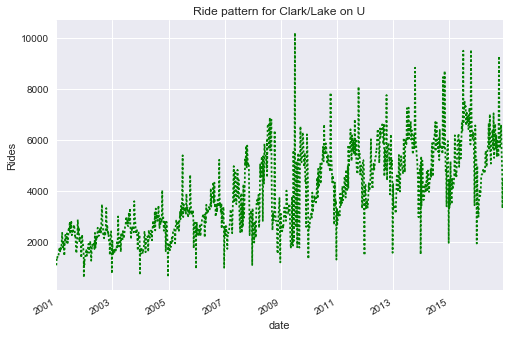

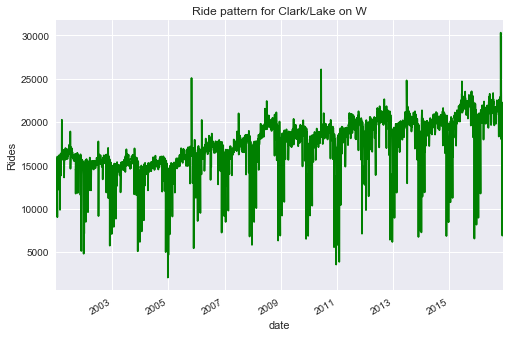

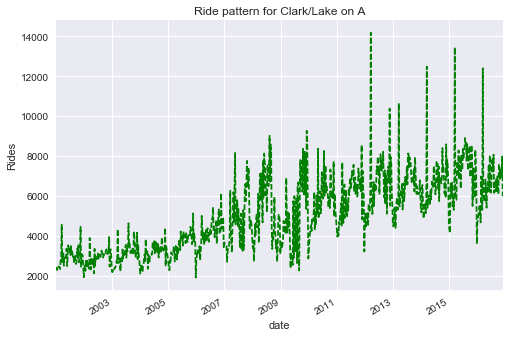

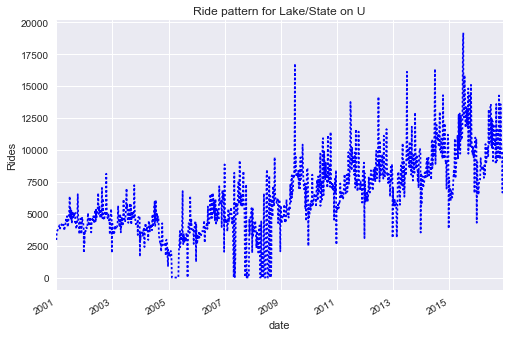

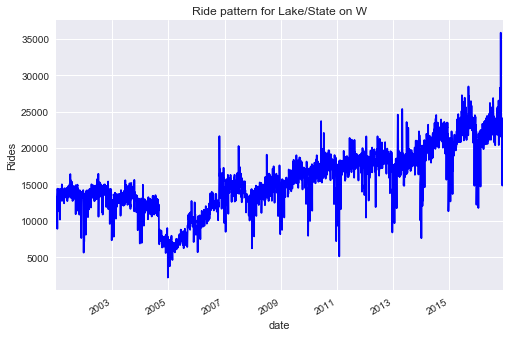

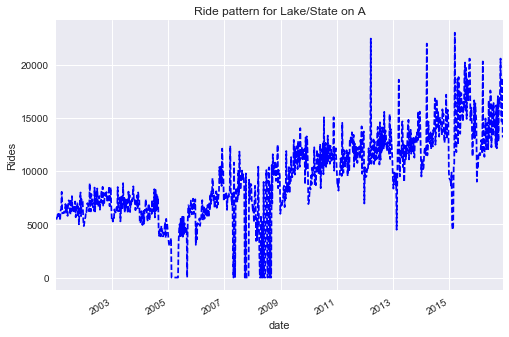

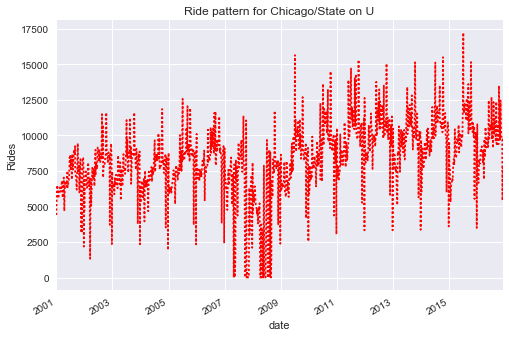

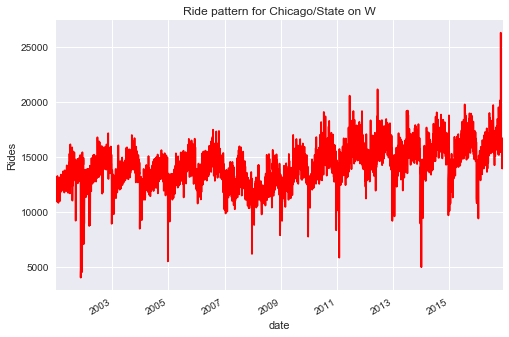

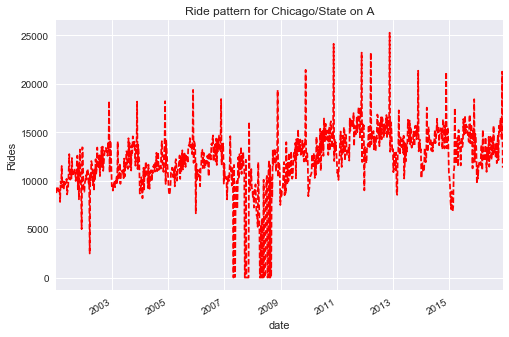

In [30]:
i,j = 0,0
for s_id in s_ids:
    cols = ['g','b','r'] # Green is Clark / Lake, Blue is Lake State, Red is Chicago / State
    i=0
    for day in date_cats:
        ls = [':','-','--'] # stars are Holidays / Sundays, lines are Weekdays, 
        tmp = df_stations[df_stations['station_id'].isin([s_id])]
        tmp = tmp[tmp['daytype'].isin([day])]
        tmp['rides'].plot(c=cols[j], linestyle=ls[i])
        
        plt.title('Ride pattern for %s on %s' % (tmp['stationname'][0],day))
        plt.ylabel('Rides')
        plt.show()
        
        i+=1
    j+=1

In [31]:
# As can be seen in the plots above Lake / State is the station that has the highest increase in passengers
# It seems like the number of riderships for all daytypes have increased since 2009
# This might be a good indication that the market at that station is untapped -- and that it will increase further

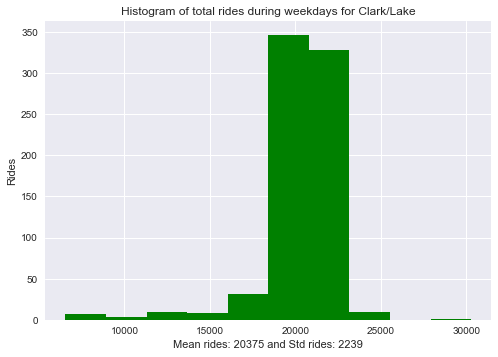

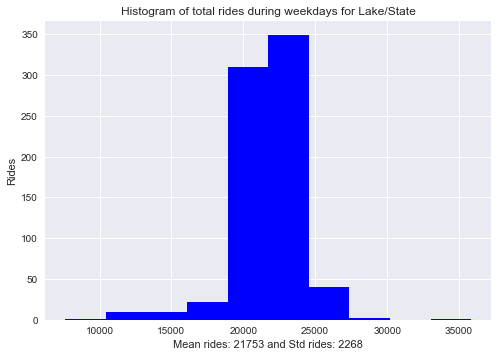

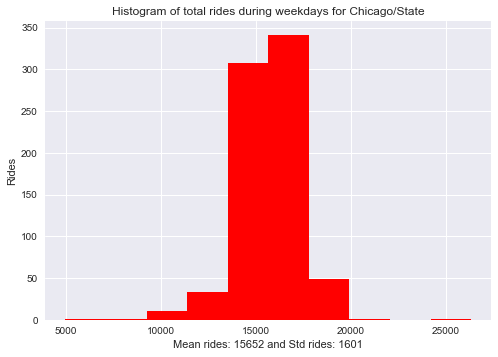

In [32]:
# We can also inspect the histogram of the riderships during the weekdays
# to see if a station has a constant number of riderships
# We also only want to look at the last three years, i.e. 2014 - 2016 -- as these seem to be most relevant

i=0
for s_id in s_ids:
        cols = ['g','b','r'] # Green is Clark / Lake, Blue is Lake State, Red is Chicago / State
        
        tmp = df_stations[df_stations['station_id'].isin([s_id])]
        tmp = tmp[tmp['daytype'].isin(['W'])]
        tmp = tmp['2014':'2016']
        
        tmp['rides'].hist(color=cols[i])
        
        plt.title('Histogram of total rides during weekdays for %s' % (tmp['stationname'][0]))
        plt.ylabel('Rides')
        plt.xlabel('Mean rides: %d and Std rides: %d' % (tmp['rides'].mean(), tmp['rides'].std()))
        plt.show()
        
        i+=1

In [33]:
# Here it becomes quite obvious that the two best choices would be either:

## Lake / State or Clark / Lake ##

In [34]:
# Let's also examine the mean ridership on Saturdays and Sundays for these two stations during the last three years

weekends = ['U','A']
tmp = df[df['daytype'].isin(weekends)]
tmp_CL = tmp[tmp['station_id'].isin([s_ids[0]])]
tmp_LS = tmp[tmp['station_id'].isin([s_ids[1]])]
print('Clark Lake mean ridership on weekends', int(tmp_CL['rides'].mean()))
print('Lake State mean ridership on weekends', int(tmp_LS['rides'].mean()))

Clark Lake mean ridership on weekends 4380
Lake State mean ridership on weekends 7693


In [35]:
# From this analysis it also looks like Lake State would be the better choice to open up the restaurant

In [36]:
# Find the locations from these two stops by utilizing the data set "list_of_stops.csv" (sent in the email)
# In order to plot them on a map
!ls

Datascope Assignment and Presentation.ipynb
chi_map.html
chi_map2.html
list_of_stops.csv
ridershipreadme.txt
station_entries.csv


In [37]:
df_stop = pd.read_csv('list_of_stops.csv')
df_stop.head()

STOP_ID DIRECTION_ID                        STOP_NAME  \
0    30162            W         18th (54th/Cermak-bound)   
1    30161            E                18th (Loop-bound)   
2    30022            N         35th/Archer (Loop-bound)   
3    30023            S       35th/Archer (Midway-bound)   
4    30214            S  35-Bronzeville-IIT (63rd-bound)   

           STATION_NAME           STATION_DESCRIPTIVE_NAME  MAP_ID   ADA  \
0                  18th                   18th (Pink Line)   40830  True   
1                  18th                   18th (Pink Line)   40830  True   
2           35th/Archer          35th/Archer (Orange Line)   40120  True   
3           35th/Archer          35th/Archer (Orange Line)   40120  True   
4  35th-Bronzeville-IIT  35th-Bronzeville-IIT (Green Line)   41120  True   

     RED   BLUE      G    BRN      P   Pexp      Y    Pnk      O  \
0  False  False  False  False  False  False  False   True  False   
1  False  False  False  False  False  False  False   True  False   
2  False  False  False  False  False  False  False  False   True   
3  False  False  False  False  False  False  False  False   True   
4  False  False   True  False  False  False  False  False  False   

                  Location  
0  (41.857908, -87.669147)  
1  (41.857908, -87.669147)  
2  (41.829353, -87.680622)  
3  (41.829353, -87.680622)  
4  (41.831677, -87.625826)

In [38]:
# MAP_ID seem to match station_id in the other data set
tmp = df_stop[df_stop['MAP_ID'].isin(s_ids[0:2])] # yes this is true
tmp

STOP_ID DIRECTION_ID                     STOP_NAME STATION_NAME  \
68     30074            E       Clark/Lake (Inner Loop)   Clark/Lake   
69     30075            W       Clark/Lake (Outer Loop)   Clark/Lake   
70     30374            S  Clark/Lake (Forest Pk-bound)   Clark/Lake   
71     30375            N     Clark/Lake (O'Hare-bound)   Clark/Lake   
190    30290            S             Lake (95th-bound)         Lake   
294    30289            N           Lake (Howard-bound)         Lake   

                              STATION_DESCRIPTIVE_NAME  MAP_ID   ADA    RED  \
68   Clark/Lake (Blue, Brown, Green, Orange, Purple...   40380  True  False   
69   Clark/Lake (Blue, Brown, Green, Orange, Purple...   40380  True  False   
70   Clark/Lake (Blue, Brown, Green, Orange, Purple...   40380  True  False   
71   Clark/Lake (Blue, Brown, Green, Orange, Purple...   40380  True  False   
190                                    Lake (Red Line)   41660  True   True   
294                                    Lake (Red Line)   41660  True   True   

      BLUE      G    BRN      P   Pexp      Y    Pnk      O  \
68   False   True  False  False   True  False   True   True   
69   False   True   True  False  False  False  False  False   
70    True  False  False  False  False  False  False  False   
71    True  False  False  False  False  False  False  False   
190  False  False  False  False  False  False  False  False   
294  False  False  False  False  False  False  False  False   

                    Location  
68   (41.885737, -87.630886)  
69   (41.885737, -87.630886)  
70   (41.885737, -87.630886)  
71   (41.885737, -87.630886)  
190  (41.884809, -87.627813)  
294  (41.884809, -87.627813)

In [39]:
locations = tmp['Location'].unique()
print(locations)

['(41.885737, -87.630886)' '(41.884809, -87.627813)']


In [40]:
import folium # for map plotting

In [41]:
# Create some statistics for the last three years, to display on the map

df_3 = pd.DataFrame(columns=['avg','std','increase'])

res = list()
i=0
for s_id in s_ids[0:2]:

    # Clark Lake (s_ids[0])
    tmp = df['2014':'2016']
    tmp = tmp[tmp['station_id']==s_ids[i]]
    
    avg_tmp = tmp['rides'].mean()
    std_tmp = tmp['rides'].std()
    
    increase_tmp = tmp['rides'].resample('A').mean()
    increase_tmp = increase_tmp - increase_tmp[0]
    increase_tmp = increase_tmp[1:3].mean()    
    res.append([avg_tmp, std_tmp, increase_tmp])
    
    i+=1


df_3=pd.DataFrame(res,columns=['avg','std','increase'],index=['Clark / Lake','Lake / State']).round(2)
    
df_3

avg      std  increase
Clark / Lake  16065.90  6873.51   1214.50
Lake / State  18797.65  5230.11   1353.76

In [42]:
chi_map = folium.Map(location=[41.885737, -87.630886], zoom_start=14) #initialize map
# locations are strings, so we copy paste it here

html_CL = '''<h1><b>Clarke / Lake</h1></br> (last 3 years statistics)</b> <br>
            Average ridership: %d <br>
            Std ridership: %d <br>
            Avg yearly increase in ridership: %d''' %(res[0][0],res[0][1],res[0][2]) # add html info


iframe = folium.IFrame(html=html_CL, width=300, height=200)
popup1 = folium.Popup(iframe, max_width=2650)
folium.Marker([41.885737, -87.630886], popup=popup1).add_to(chi_map) # add first popup to CL location


html_LS = '''<h1><b>Lake / State</h1></br> (last 3 years statistics)</b> <br>
            Average ridership: %d <br>
            Std ridership: %d <br>
            Avg yearly increase in ridership: %d''' %(res[1][0],res[1][1],res[1][2]) # add LS html info


iframe2 = folium.IFrame(html=html_LS, width=300, height=200)
popup2 = folium.Popup(iframe2, max_width=2650)

folium.Marker([41.884809, -87.627813], popup=popup2).add_to(chi_map)

chi_map.save('chi_map.html') # save map as html file

In [43]:
from IPython.display import IFrame
IFrame('chi_map.html', width=900, height=500)

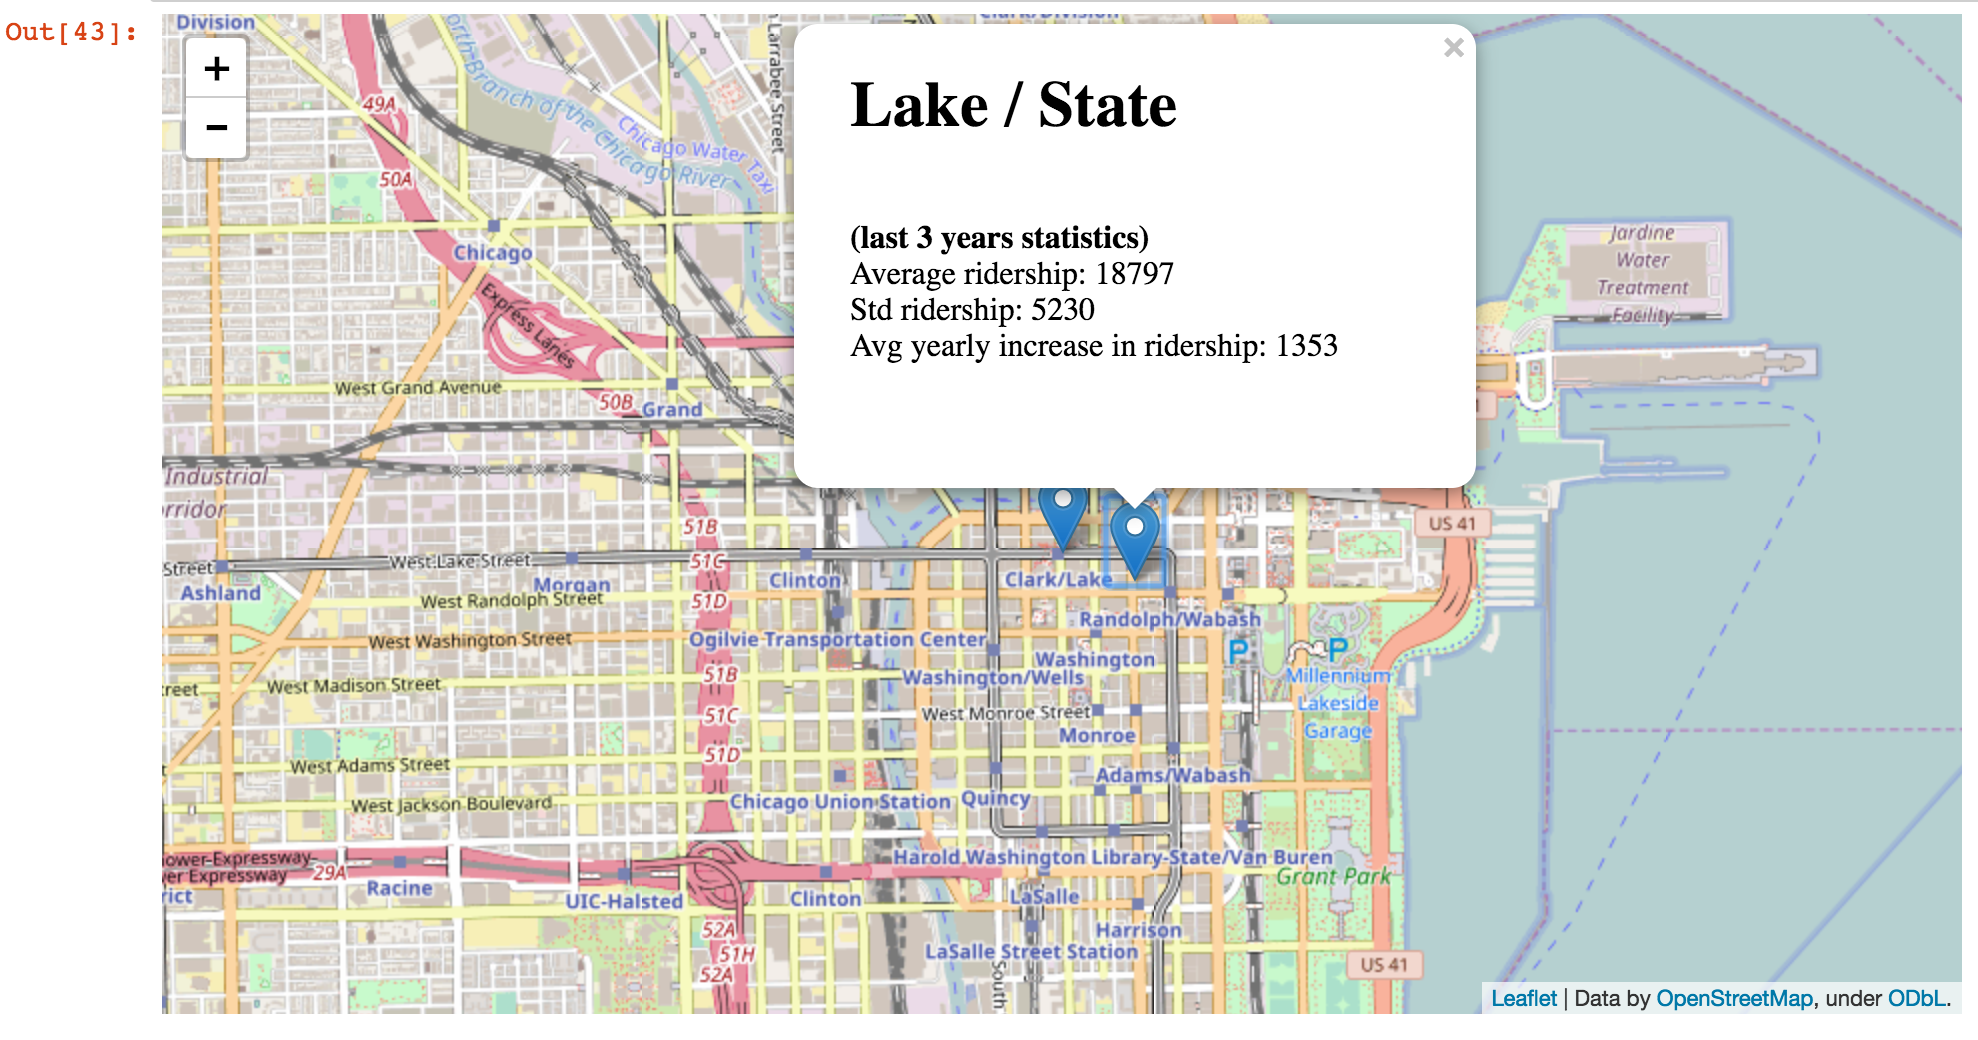

In [46]:
# HTML output does not show on Github, showing screenshot
from IPython.display import Image
Image(filename='chi_map_screenshot.png') 

In [47]:
# Create visual over ridership for these two stations, during the last two years
tmp = df['2014':'2016']
tmp = tmp[tmp['station_id'].isin(s_ids[0:2])]
tmp = tmp.pivot(columns='stationname', values='rides')
tmp.head()

stationname  Clark/Lake  Lake/State
date                               
2014-01-01         5354        8189
2014-01-02        16130       16408
2014-01-03        16946       16885
2014-01-04         5186        9497
2014-01-05         3428        5725

In [48]:
import vincent
vincent.core.initialize_notebook()
lines = vincent.Line(tmp,width=400,height=200)
lines.axis_titles(x='DATES', y='RIDES\n.')
lines.colors(brew='Set3')
lines.legend(title='Subway stops')

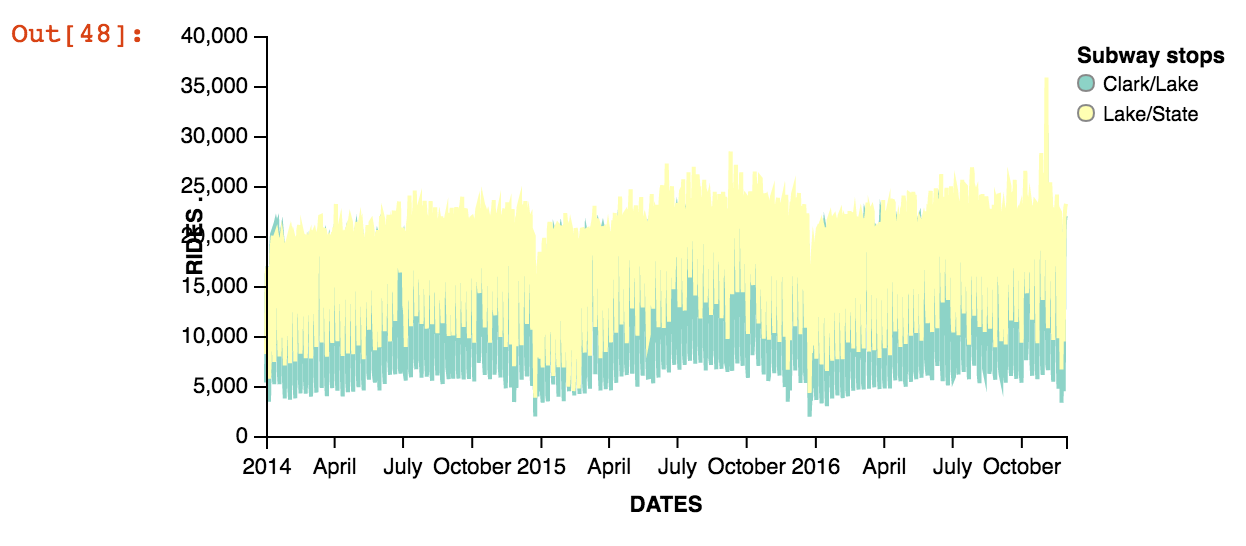

In [49]:
# vincent output does not show on Github, showing screenshot
Image(filename='vincent_screenshot.png')

In [50]:
# Let's create a Vega popup based on scatter_chart.
popup3 = folium.Popup(iframe,max_width=800)
folium.Vega(lines, height=250, width=520).add_to(popup3)

folium.RegularPolygonMarker([41.875809, -87.643813], popup=popup3).add_to(chi_map)
chi_map.save('chi_map2.html') # save map as html file

In [51]:
IFrame('chi_map2.html', width=900, height=500)

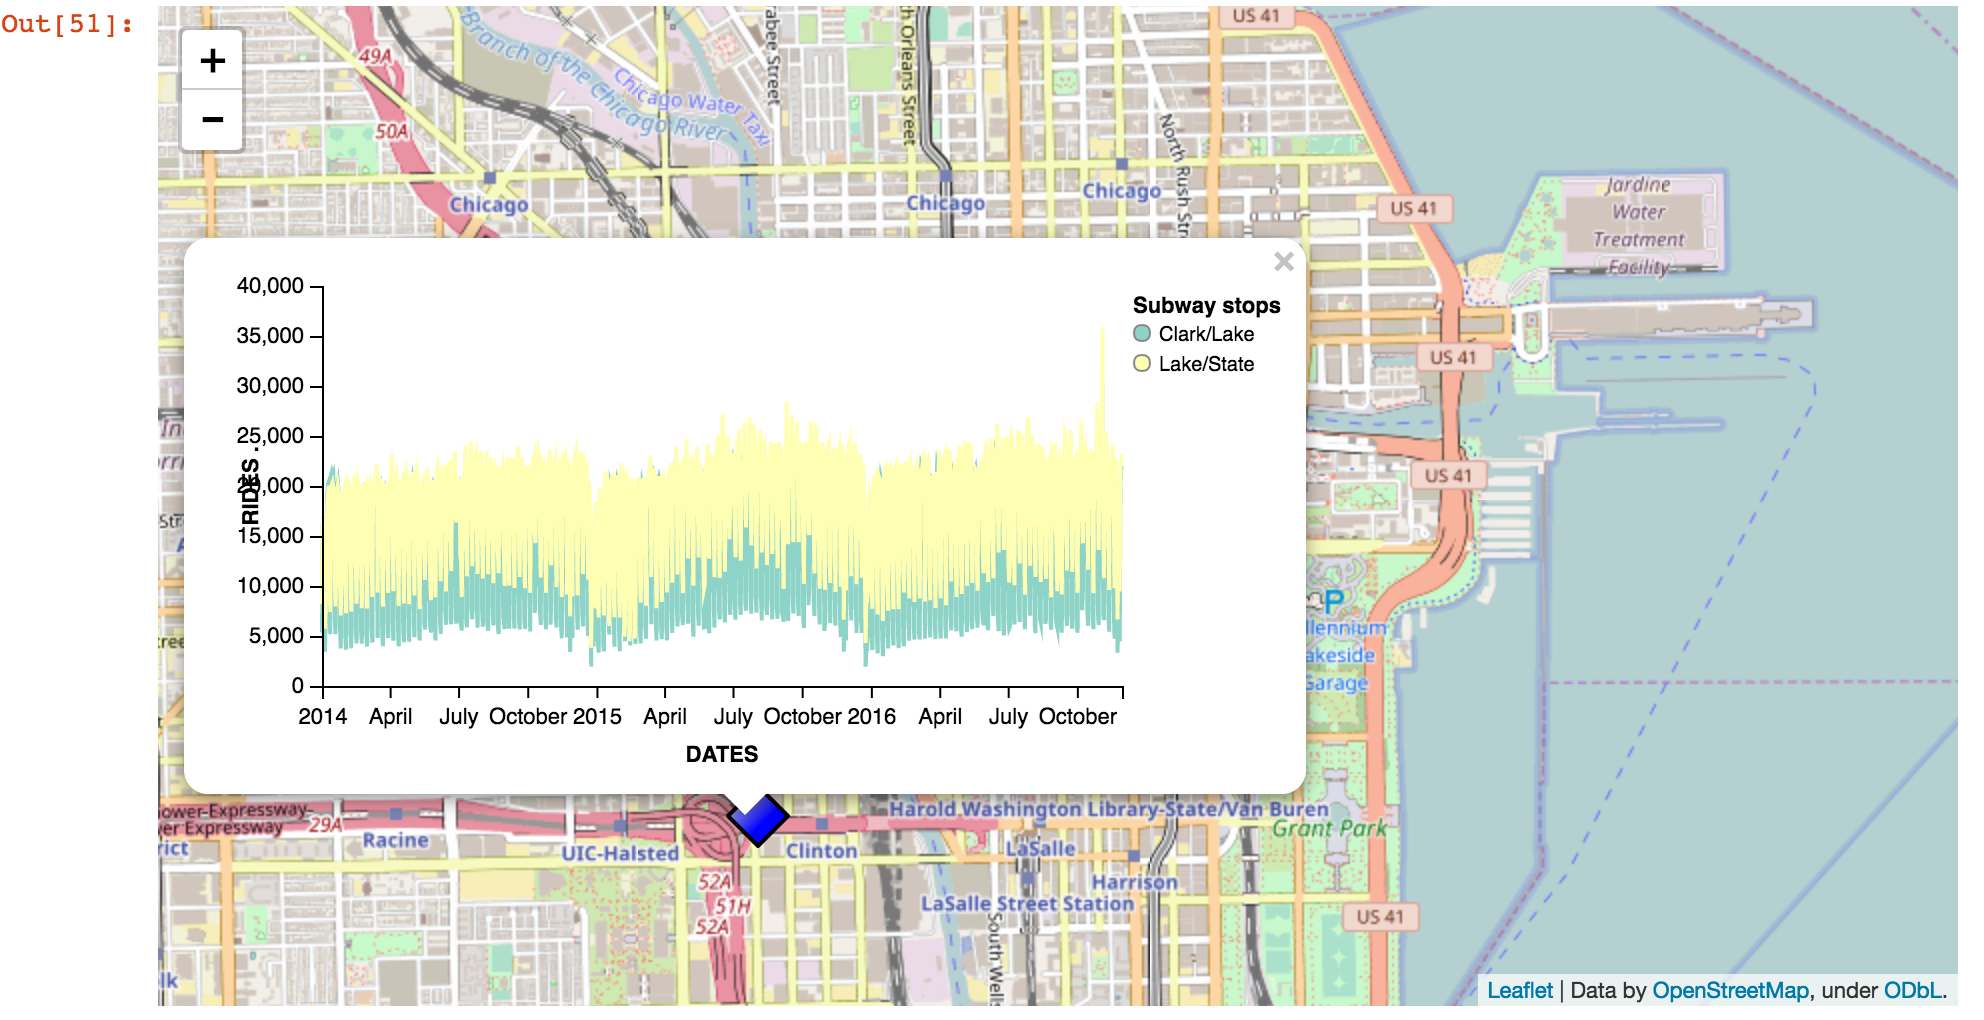

In [52]:
Image(filename='chi_map2_screenshot.png')